<a href="https://colab.research.google.com/github/WHU-Peter/COMP6248-Deep-Learning/blob/master/DL_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer
import torch
from torchvision import transforms 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchbearer import Trial
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import torchbearer

     |████████████████████████████████| 143kB 12.3MB/s 


In [2]:
class MyDataset(Dataset):
  def __init__(self , size=5000, dim=40, random_offset=0):
    super(MyDataset , self ).__init__() 
    self.size = size
    self.dim = dim
    self.random_offset = random_offset

  def __getitem__( self , index ): 
    if index>=len(self):
      raise IndexError('{} index out of range'.format(self.__class__.__name__))
    rng_state = torch.get_rng_state()
    torch.manual_seed(index + self .random_offset)
    while True :
      img = torch.zeros(self.dim, self.dim)
      dx = torch.randint(-10,10,(1,),dtype=torch.float) 
      dy = torch.randint(-10,10,(1,),dtype=torch.float) 
      c = torch.randint(-20,20,(1,) , dtype=torch.float)

      params = torch.cat((dy/dx, c))
      xy = torch.randint(0,img.shape[1] , (20, 2), dtype=torch.float)
      xy[: ,1] = xy[: ,0] * params[0] + params[1]
      xy.round_()
      xy = xy[ xy[:,1] > 0 ]
      xy = xy[ xy[:,1] < self.dim ] 
      xy = xy[ xy[:,0] < self.dim ]
      for i in range(xy.shape[0]):
        x, y = xy[i][0], self.dim - xy[i][1] 
        img[int(y), int(x)]=1
      if img.sum() > 2: 
        break
    torch.set_rng_state(rng_state) 
    return img.unsqueeze(0), params
  
  def __len__(self):
    return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333) 
test_data = MyDataset(size=500, random_offset=99999)

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [3]:
from torchbearer import callbacks
import numpy as np
import matplotlib.pyplot as plt

epochs=100
Train_Loss = np.zeros(epochs)
Val_Loss = np.zeros(epochs)

@callbacks.on_end_epoch
def my_callback(state):
  Train_Loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  Val_Loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']

def plot():
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
  ax[0].plot(Train_Loss, c='m')
  ax[0].grid(True)
  ax[0].set_xlabel("Iteration", fontsize=14)
  ax[0].set_ylabel("Train_Loss", fontsize=14)
  ax[0].set_title("Traing Set", fontsize=14)
  ax[0].set_ylim(0,65)
  ax[1].plot(Val_Loss, c='r')
  ax[1].grid(True)
  ax[1].set_xlabel("Iteration", fontsize=14)
  ax[1].set_ylabel("Test_Loss", fontsize=14)
  ax[1].set_title("Test Set", fontsize=14)
  ax[1].set_ylim(0,65)
  # ax[1,0].plot(Train_Acc, c='m')
  # ax[1,0].grid(True)
  # ax[1,0].set_xlabel("Iteration", fontsize=14)
  # ax[1,0].set_ylabel("Train_Accuracy", fontsize=14)
  # ax[1,0].set_title("Traing Set", fontsize=14)
  # ax[1,1].plot(Test_Acc, c='r')
  # ax[1,1].grid(True)
  # ax[1,1].set_xlabel("Iteration", fontsize=14)
  # ax[1,1].set_ylabel("Test_Accuracy", fontsize=14)
  # ax[1,1].set_title("Test Set", fontsize=14)
  plt.show()

In [4]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48 * 40**2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

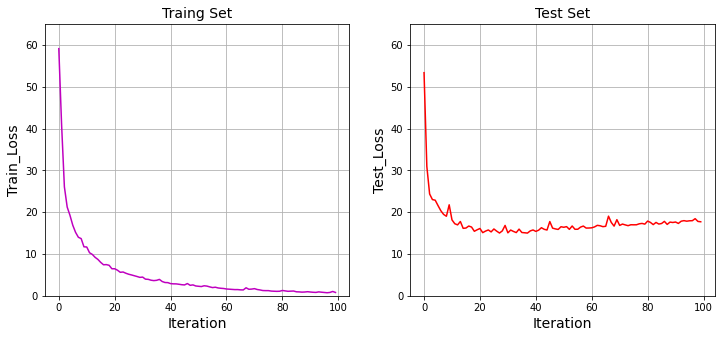

In [5]:
# build the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = RegressionCNN()
model.to(device)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())
Train_Loss = np.zeros(epochs)
Val_Loss = np.zeros(epochs)

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'acc'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator=valloader, test_generator=testloader)
trial.run(epochs)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)
plot()

In [16]:
class RegressionCNN2(nn.Module):
    def __init__(self):
        super(RegressionCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = nn.AdaptiveMaxPool2d(1)(out)
        out = out.view(out.shape[0], -1)
        # out = F.dropout(out, 0.3)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

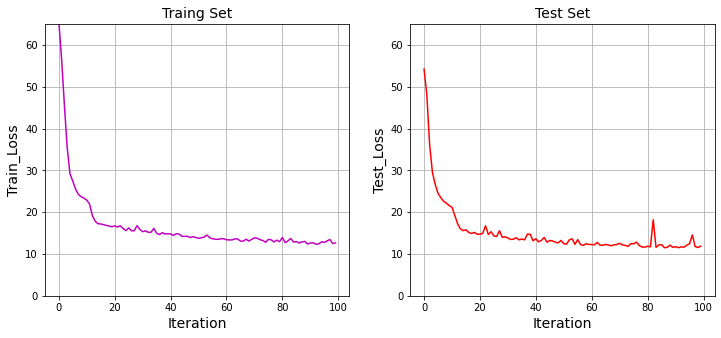

In [17]:
# build the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = RegressionCNN2()
model.to(device)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())
Train_Loss = np.zeros(epochs)
Val_Loss = np.zeros(epochs)

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'acc'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator=valloader, test_generator=testloader)
trial.run(epochs)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)
plot()

In [18]:
class RegressionCNN3(nn.Module):
    def __init__(self):
        super(RegressionCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0) 
        x = torch.cat([x, idx], dim=1)

        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = nn.AdaptiveMaxPool2d(1)(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

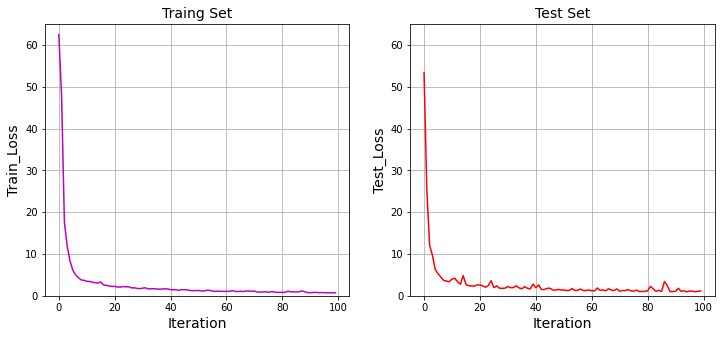

In [19]:
# build the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = RegressionCNN3()
model.to(device)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())
Train_Loss = np.zeros(epochs)
Val_Loss = np.zeros(epochs)

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'acc'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator=valloader, test_generator=testloader)
trial.run(epochs=100)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)
plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 40, 40])


Text(0.5, 1.0, '3 channel input')

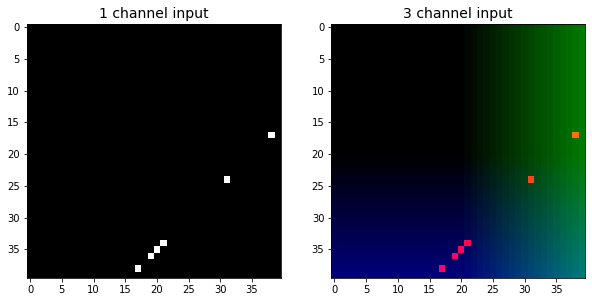

In [20]:
picture = train_data.__getitem__(1)[0]
print(picture.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(picture.squeeze(0), cmap=plt.get_cmap('gray'))
ax[0].set_title("1 channel input", fontsize=14)

idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0)
idxy = idxx.clone().t()
idx = torch.stack([idxx, idxy])
idx = torch.repeat_interleave(idx, repeats=picture.shape[0], dim=0) 
picture = torch.cat([picture, idx], dim=0)
picture = picture.numpy().transpose(1,2,0)
ax[1].imshow(picture)
ax[1].set_title("3 channel input", fontsize=14)